In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time

from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from feature_engine.selection import DropConstantFeatures, DropDuplicateFeatures, SmartCorrelatedSelection
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn import metrics

In [2]:
train = pd.read_csv("train_B.csv")
val = pd.read_csv("val_B.csv")
test = pd.read_csv("test_B.csv")

In [3]:
import pandas as pd

# Etiquetas de ataques
ataques = [
    'DDoS-HTTP_Flood', 'DDoS-SYN_Flood', 'DDoS-UDP_Flood',
    'DoS-SYN_Flood', 'DoS-UDP_Flood', 'DoS-HTTP_Flood',
    'Recon-PortScan', 'Recon-OSScan', 'Recon-HostDiscovery'
]

porcentaje_mantener = 0.1111170  # Fracción a mantener por clase/protocolo

def reducir_df(df):
    muestras_filtradas = []

    for ataque in ataques:
        df_ataque = df[df['category'] == ataque]

        df_tcp = df_ataque[df_ataque['proto'] == 0]
        df_udp = df_ataque[df_ataque['proto'] == 1]

        tcp_sample = df_tcp.sample(frac=porcentaje_mantener, random_state=42)
        udp_sample = df_udp.sample(frac=porcentaje_mantener, random_state=42)


        tcp_sample = tcp_sample.copy()
        udp_sample = udp_sample.copy()
        tcp_sample['ataque_original'] = ataque
        udp_sample['ataque_original'] = ataque

        muestras_filtradas.append(pd.concat([tcp_sample, udp_sample]))

   
    df_benigno = df[df['category'] == 'Benign'].copy()
    df_benigno['ataque_original'] = 'Benign'

    df_reducido = pd.concat(muestras_filtradas + [df_benigno])

    df_reducido['category'] = df_reducido['category'].apply(lambda x: 'Attack' if x in ataques else x)

    return df_reducido

# Aplicar a los datasets
train = reducir_df(train)
test = reducir_df(test)
val = reducir_df(val)


In [5]:
# Separar características y etiquetas para conjunto de entrenamiento
X_train = train.drop(columns=['category', 'ataque_original'])
y_train = train['category']
label_train = train['ataque_original']

# Separar características y etiquetas para conjunto de prueba
X_test = test.drop(columns=['category', 'ataque_original'])
y_test = test['category']
label_test = test['ataque_original']

X_val = val.drop(columns=['category', 'ataque_original'])
y_val = val['category']
label_val = val['ataque_original']

In [6]:
RF = RandomForestClassifier()

param_grid = {'n_estimators': [15], 'max_depth': [15]} 
grid = GridSearchCV(RF, param_grid, cv=5, scoring='accuracy', return_train_score=True, verbose=1)
grid.fit(X_train, y_train)

print('Best Cross Validation Score:', grid.best_score_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best Cross Validation Score: 0.884087511923845


In [7]:
RF =  grid.best_estimator_

print('Train Score:', RF.score(X_train, y_train))

y_pred = RF.predict(X_test)

start2=time.time()
print('Precision en test: ', accuracy_score(y_test, y_pred))
stop2=time.time()


tiempo2 = stop2 - start2
print(f"Tiempo de prediccion (Test) RF: {tiempo2}s")

Train Score: 0.9739189165011719
Precision en test:  0.9690674848546517
Tiempo de prediccion (Test) RF: 0.06289243698120117s


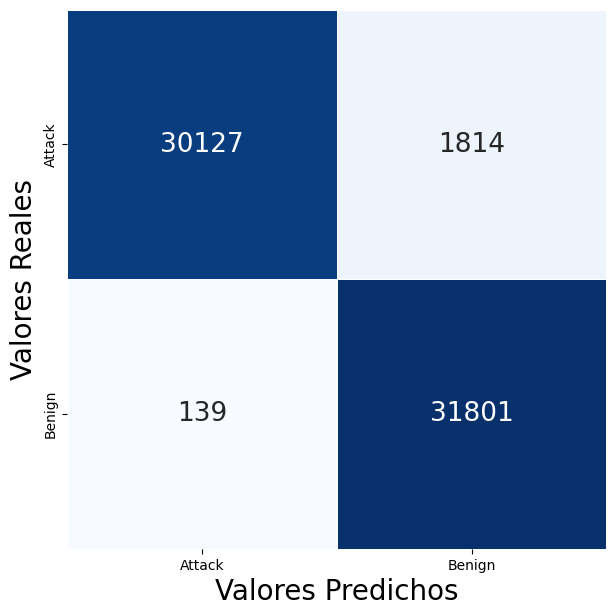

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

# Confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)
normalized_matrix = cm  # O normaliza si quieres: cm / cm.sum(axis=1, keepdims=True)

class_names = ['Attack', 'Benign']

# Plot
sns.heatmap(
    normalized_matrix, 
    annot=True, 
    fmt='0.0f', 
    linewidth=0.5,
    annot_kws={"size": 19}, 
    xticklabels=class_names,
    yticklabels=class_names, 
    square=True, 
    cmap='Blues', 
    cbar=False
)

fig = plt.gcf()
fig.set_size_inches(7, 7)
plt.ylabel('Valores Reales', fontsize=20)
plt.xlabel('Valores Predichos', fontsize=20)

# Guardar como PDF (¡hazlo antes del plt.show!)
plt.savefig('CM_RF_33car_2Class.pdf', format='pdf', bbox_inches='tight')

plt.show()


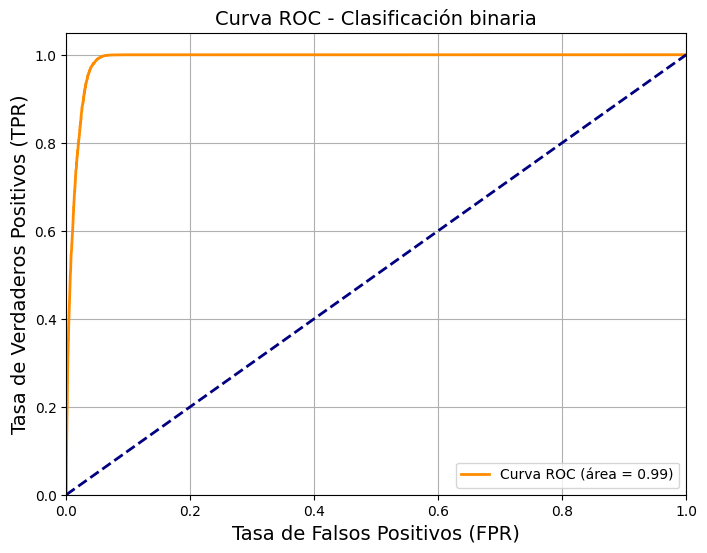

In [18]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Predecir probabilidades
y_pred_prob = RF.predict_proba(X_test)

# Obtener el índice de la clase 'Benign' (clase positiva)
idx_benign = np.where(RF.classes_ == 'Benign')[0][0]

# Probabilidades de que una muestra sea Benign
y_scores = y_pred_prob[:, idx_benign]

# Convertir y_test a binario: 1 = Benign, 0 = Attack
y_true_binary = np.array([1 if y == 'Benign' else 0 for y in y_test])

# Calcular curva ROC
fpr, tpr, thresholds = roc_curve(y_true_binary, y_scores)
roc_auc = auc(fpr, tpr)

# Graficar
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label=f'Curva ROC (área = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)', fontsize=14)
plt.ylabel('Tasa de Verdaderos Positivos (TPR)', fontsize=14)
plt.title('Curva ROC - Clasificación binaria', fontsize=14)
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig('ROC_RF_33car_Binaria.pdf', format='pdf', bbox_inches='tight')
plt.show()


In [6]:
RF = RandomForestClassifier(n_estimators=15, max_depth=15)

RF.fit(X_train, y_train)
y_pred = RF.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.9688639814655375


In [8]:
import joblib 
# Guardar el modelo entrenado
joblib.dump(RF, 'RF_model1.pkl')

['RF_model1.pkl']

In [8]:
import joblib
RF = joblib.load('RF_model1.pkl')

y_pred = RF.predict(X_test)
print('Precision en test: ', accuracy_score(y_test, y_pred))

Precision en test:  0.9693649128848953


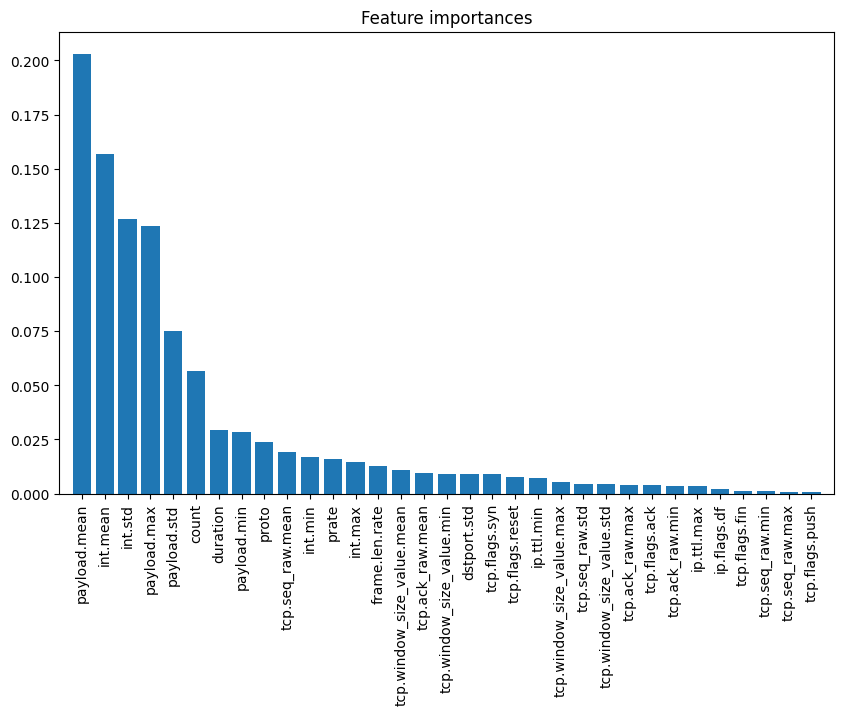

In [6]:
importances = RF.feature_importances_
#plotamos la importancia de las variables
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 6))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [9]:
sel = SelectFromModel(RF, threshold=0.0105, prefit=True)
sel.fit(X_train, y_train)

SelectFromModel(estimator=RandomForestClassifier(max_depth=15, n_estimators=15),
                prefit=True, threshold=0.0105)

In [10]:
# let's make a list and count the selected features

selected_feat = X_train.columns[(sel.get_support())]

len(selected_feat)

if "proto" not in selected_feat:
    selected_feat = selected_feat.append(pd.Index(["proto"]))
    
X_train = X_train[selected_feat]
X_val = X_val[selected_feat]
X_test = X_test[selected_feat]

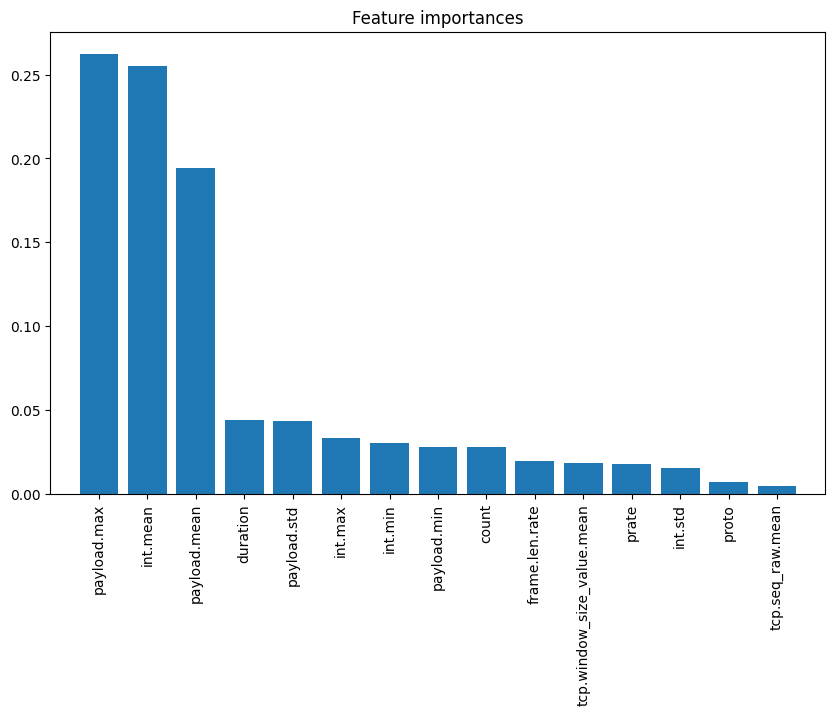

In [19]:
importances = RF.feature_importances_
#plotamos la importancia de las variables
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 6))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [11]:
RF = RandomForestClassifier()

param_grid = {'n_estimators': [15], 'max_depth': [15]} 
grid = GridSearchCV(RF, param_grid, cv=5, scoring='accuracy', return_train_score=True, verbose=1)
grid.fit(X_train, y_train)

print('Best Cross Validation Score:', grid.best_score_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best Cross Validation Score: 0.8563965704660076


In [12]:
RF =  grid.best_estimator_

print('Train Score:', RF.score(X_train, y_train))

y_pred = RF.predict(X_test)

start2=time.time()
print('Precision en test: ', accuracy_score(y_test, y_pred))
stop2=time.time()


tiempo2 = stop2 - start2
print(f"Tiempo de prediccion (Test) RF: {tiempo2}s")

Train Score: 0.9755291360277674
Precision en test:  0.9678464645199668
Tiempo de prediccion (Test) RF: 0.06223773956298828s


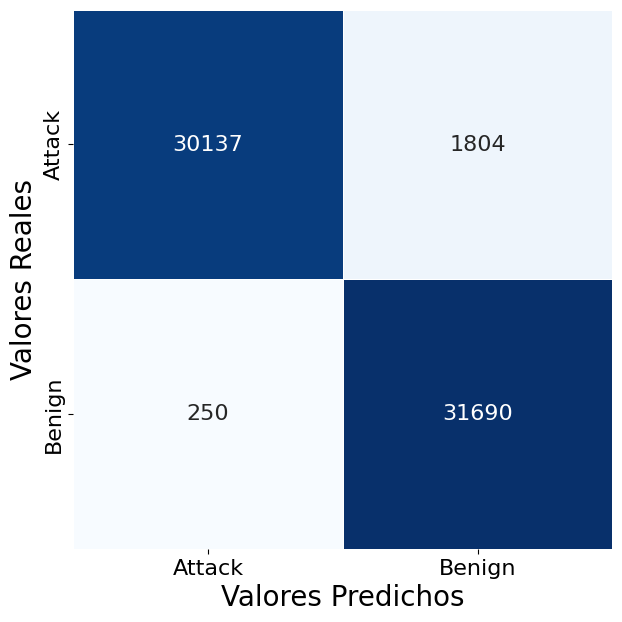

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

# Confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)
normalized_matrix = cm  # O normaliza si quieres: cm / cm.sum(axis=1, keepdims=True)

class_names = ['Attack', 'Benign']

# Plot
sns.heatmap(
    normalized_matrix, 
    annot=True, 
    fmt='0.0f', 
    linewidth=0.5,
    annot_kws={"size": 16}, 
    xticklabels=class_names,
    yticklabels=class_names, 
    square=True, 
    cmap='Blues', 
    cbar=False
)

fig = plt.gcf()
fig.set_size_inches(7, 7)
plt.ylabel('Valores Reales', fontsize=20)
plt.xlabel('Valores Predichos', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# Guardar como PDF (¡hazlo antes del plt.show!)
plt.savefig('CM_RF_15car_2Class.pdf', format='pdf', bbox_inches='tight')

plt.show()


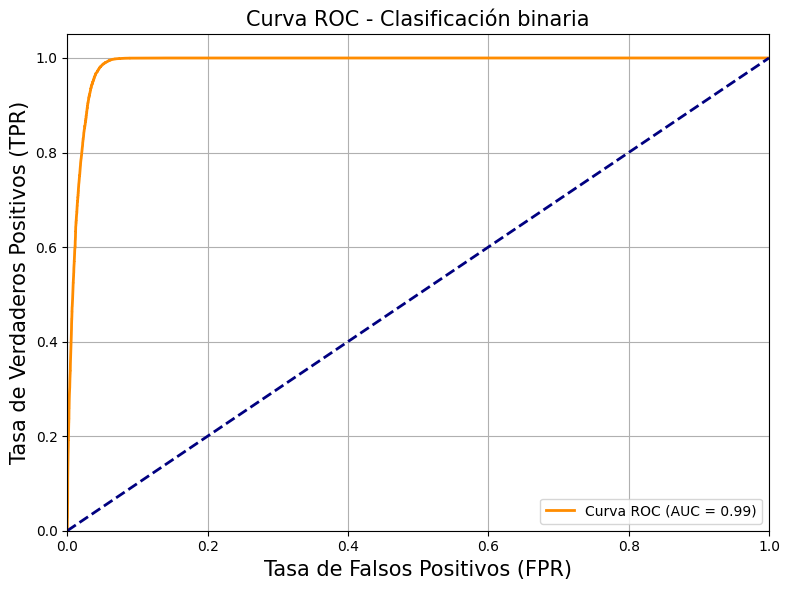

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Obtener probabilidades predichas por el modelo
y_pred_prob = RF.predict_proba(X_test)

# Índice de la clase 'Benign' (la que consideramos como positiva)
idx_benign = np.where(RF.classes_ == 'Benign')[0][0]
y_scores = y_pred_prob[:, idx_benign]

# Convertir y_test a binario: 1 = Benign, 0 = Attack
y_true_binary = np.array([1 if y == 'Benign' else 0 for y in y_test])

# Calcular la curva ROC y el AUC
fpr, tpr, _ = roc_curve(y_true_binary, y_scores)
roc_auc = auc(fpr, tpr)

# Graficar la curva
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)', fontsize=15)
plt.ylabel('Tasa de Verdaderos Positivos (TPR)', fontsize=15)
plt.title('Curva ROC - Clasificación binaria', fontsize=15)
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.savefig('ROC_RF_Binary.pdf', format='pdf')
plt.show()


In [14]:
import numpy as np

genuinos = []
impostores = []

y_test = np.array(y_test).ravel()
idx_benign = np.where(RF.classes_ == 'Benign')[0][0]

for i in range(len(y_test)):
    score_benign = y_pred_prob[i][idx_benign]
    etiqueta_real = y_test[i]
    
    if etiqueta_real == 'Benign':
        # Genuino: modelo asigna score a Benign y realmente lo es
        genuinos.append(score_benign)
    else:
        # Impostor: modelo asigna score a Benign pero no lo es
        impostores.append(score_benign)

# Convertimos a arrays para análisis numérico
genuinos = np.array(genuinos)
impostores = np.array(impostores)

print("Genuinos:", genuinos.shape)
print("Impostores:", impostores.shape)


Genuinos: (31940,)
Impostores: (31941,)


In [15]:
thresholds = np.arange(-0.001, 1.001, 0.001)
FAR = []
FRR = []
for threshold in thresholds:
    FAR.append(np.sum(impostores >= threshold) / len(impostores))
    FRR.append(np.sum(genuinos <= threshold) / len(genuinos))

# Imprimir FAR, FRR
print("FAR:", FAR)
print("FRR:", FRR)

FAR: [np.float64(1.0), np.float64(1.0), np.float64(0.12166181396950627), np.float64(0.11183118875426568), np.float64(0.1095144172067249), np.float64(0.10685326069941455), np.float64(0.10638364484518331), np.float64(0.10566356720202874), np.float64(0.10506872045333583), np.float64(0.10416079646848878), np.float64(0.10347202654894963), np.float64(0.10278325662941047), np.float64(0.10231364077517924), np.float64(0.10203187126264049), np.float64(0.10193794809179424), np.float64(0.10162487085564009), np.float64(0.10140571679033218), np.float64(0.10131179361948593), np.float64(0.10115525500140884), np.float64(0.1010613318305626), np.float64(0.10096740865971635), np.float64(0.10084217776525468), np.float64(0.10081087004163927), np.float64(0.10071694687079302), np.float64(0.10056040825271595), np.float64(0.10049779280548511), np.float64(0.10040386963463886), np.float64(0.10034125418740804), np.float64(0.10021602329294638), np.float64(0.09999686922763845), np.float64(0.09993425378040763), np.fl

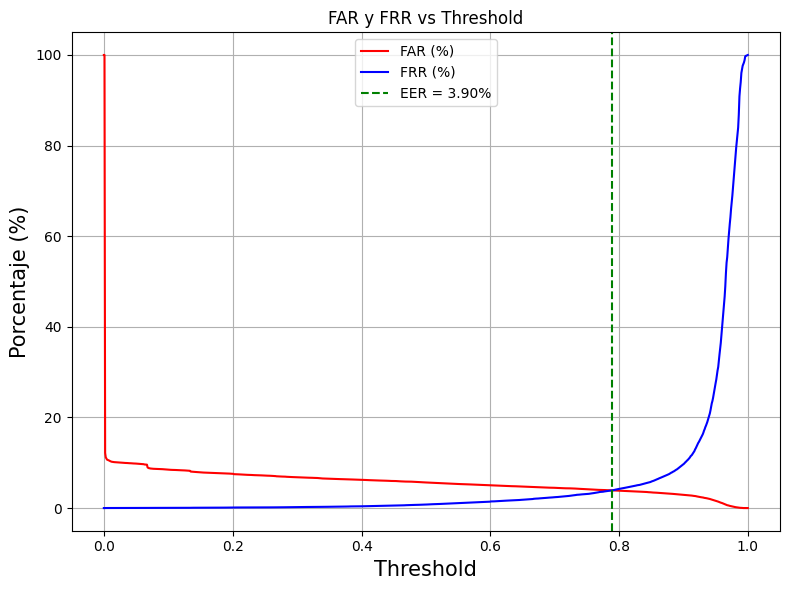

In [16]:
FAR_porcentaje = np.array(FAR) * 100
FRR_porcentaje = np.array(FRR) * 100

# Calcular EER
eer_threshold_index = np.nanargmin(np.abs(FAR_porcentaje - FRR_porcentaje))
eer_threshold = thresholds[eer_threshold_index]
eer = FAR_porcentaje[eer_threshold_index]

plt.figure(figsize=(8, 6))
plt.plot(thresholds, FAR_porcentaje, label='FAR (%)', color='red')
plt.plot(thresholds, FRR_porcentaje, label='FRR (%)', color='blue')
plt.axvline(eer_threshold, color='green', linestyle='--', label=f'EER = {eer:.2f}%')

plt.xlabel('Threshold', fontsize=15)
plt.ylabel('Porcentaje (%)', fontsize=15)
plt.title('FAR y FRR vs Threshold')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig('FAR_FRR_RF_2CLASS.pdf', format='pdf', bbox_inches='tight')
plt.show()


In [21]:
import joblib
joblib.dump(RF, 'RF_model2.pkl')

['RF_model2.pkl']

In [10]:
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
label_train = label_train.reset_index(drop=True)
train = pd.concat([X_train, y_train, label_train], axis=1)

X_val_reducido = X_val.reset_index(drop=True)
y_val_reducido = y_val.reset_index(drop=True)
label_val = label_val.reset_index(drop=True)
val = pd.concat([X_val_reducido, y_val_reducido, label_val], axis=1)

X_test_reducido = X_test.reset_index(drop=True)
y_test_reducido = y_test.reset_index(drop=True)
label_test = label_test.reset_index(drop=True)
test = pd.concat([X_test_reducido, y_test_reducido, label_test], axis=1)


In [11]:
train.to_csv('train_QNN.csv', index=False)
test.to_csv('test_QNN.csv', index=False)
val.to_csv('val_QNN.csv', index=False)